# Dependencies

## Getting the datasets

In [1]:
!git clone https://github.com/maziarraissi/PINNs

Klone nach 'PINNs' ...
remote: Enumerating objects: 741, done.
remote: Total 741 (delta 0), reused 0 (delta 0), pack-reused 741
Empfange Objekte: 100% (741/741), 474.47 MiB | 10.68 MiB/s, Fertig.
Löse Unterschiede auf: 100% (66/66), Fertig.
Aktualisiere Dateien: 100% (561/561), Fertig.


## Setting up modules

TeX packages

In [2]:
!sudo apt-get -qq install texlive-fonts-recommended texlive-fonts-extra dvipng

Password:


Pip modules

In [5]:
!pip install tensorflow pyDOE

  Using cached pyDOE-0.3.8-py3-none-any.whl
  Using cached tensorflow-2.3.1-cp37-cp37m-macosx_10_9_x86_64.whl (165.1 MB)


## Import libraries

In [1]:
import sys
import os
import tensorflow as tf
import numpy as np
import tensorflow_probability as tfp

# Manually making sure the numpy random seeds are "the same" on all devices
np.random.seed(1234)
tf.random.set_seed(1234)

## Utilities: Data preparation, logger class and plotting function

In [2]:
import scipy.io
import numpy as np
import tensorflow as tf
import time
from datetime import datetime
from pyDOE import lhs
import os
import sys
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from scipy.interpolate import griddata
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable

# "." for Colab/VSCode, and ".." for GitHub
repoPath = os.path.join(".", "PINNs")
# repoPath = os.path.join("..", "PINNs")
utilsPath = os.path.join(repoPath, "Utilities")
dataPath = os.path.join(repoPath, "main", "Data")
appDataPath = os.path.join(repoPath, "appendix", "Data")

sys.path.insert(0, utilsPath)
from plotting import newfig, savefig

# prepare data
def prep_data(path, N_u=None, N_f=None, N_n=None, q=None, ub=None, lb=None, noise=0.0, idx_t_0=None, idx_t_1=None, N_0=None, N_1=None):
    # Reading external data [t is 100x1, usol is 256x100 (solution), x is 256x1]
    data = scipy.io.loadmat(path)

    # Flatten makes [[]] into [], [:,None] makes it a column vector
    t = data['t'].flatten()[:,None] # T x 1
    x = data['x'].flatten()[:,None] # N x 1

    # Keeping the 2D data for the solution data (real() is maybe to make it float by default, in case of zeroes)
    Exact_u = np.real(data['usol']).T # T x N

    if N_n != None and q != None and ub != None and lb != None and idx_t_0 != None and idx_t_1 != None:
      dt = t[idx_t_1] - t[idx_t_0]
      idx_x = np.random.choice(Exact_u.shape[1], N_n, replace=False) 
      x_0 = x[idx_x,:]
      u_0 = Exact_u[idx_t_0:idx_t_0+1,idx_x].T
      u_0 = u_0 + noise*np.std(u_0)*np.random.randn(u_0.shape[0], u_0.shape[1])
        
      # Boudanry data
      x_1 = np.vstack((lb, ub))
      
      # Test data
      x_star = x
      u_star = Exact_u[idx_t_1,:]

      # Load IRK weights
      tmp = np.float32(np.loadtxt(os.path.join(utilsPath, "IRK_weights", "Butcher_IRK%d.txt" % (q)), ndmin = 2))
      IRK_weights = np.reshape(tmp[0:q**2+q], (q+1,q))
      IRK_times = tmp[q**2+q:]

      return x, t, dt, Exact_u, x_0, u_0, x_1, x_star, u_star, IRK_weights, IRK_times

    # Meshing x and t in 2D (256,100)
    X, T = np.meshgrid(x,t)

    # Preparing the inputs x and t (meshed as X, T) for predictions in one single array, as X_star
    X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))

    # Preparing the testing u_star
    u_star = Exact_u.flatten()[:,None]
                
    # Noiseless data TODO: add support for noisy data    
    idx = np.random.choice(X_star.shape[0], N_u, replace=False)
    X_u_train = X_star[idx,:]
    u_train = u_star[idx,:]

    if N_0 != None and N_1 != None:
      Exact_u = Exact_u.T
      idx_x = np.random.choice(Exact_u.shape[0], N_0, replace=False)
      x_0 = x[idx_x,:]
      u_0 = Exact_u[idx_x,idx_t_0][:,None]
      u_0 = u_0 + noise*np.std(u_0)*np.random.randn(u_0.shape[0], u_0.shape[1])
          
      idx_x = np.random.choice(Exact_u.shape[0], N_1, replace=False)
      x_1 = x[idx_x,:]
      u_1 = Exact_u[idx_x,idx_t_1][:,None]
      u_1 = u_1 + noise*np.std(u_1)*np.random.randn(u_1.shape[0], u_1.shape[1])
      
      dt = np.asscalar(t[idx_t_1] - t[idx_t_0])        
      q = int(np.ceil(0.5*np.log(np.finfo(float).eps)/np.log(dt)))

      # Load IRK weights
      tmp = np.float32(np.loadtxt(os.path.join(utilsPath, "IRK_weights", "Butcher_IRK%d.txt" % (q)), ndmin = 2))
      weights =  np.reshape(tmp[0:q**2+q], (q+1,q))     
      IRK_alpha = weights[0:-1,:]
      IRK_beta = weights[-1:,:] 
      return x_0, u_0, x_1, u_1, x, t, dt, q, Exact_u, IRK_alpha, IRK_beta

    if N_f == None:
      lb = X_star.min(axis=0)
      ub = X_star.max(axis=0) 
      return x, t, X, T, Exact_u, X_star, u_star, X_u_train, u_train, ub, lb

    # Domain bounds (lowerbounds upperbounds) [x, t], which are here ([-1.0, 0.0] and [1.0, 1.0])
    lb = X_star.min(axis=0)
    ub = X_star.max(axis=0) 
    # Getting the initial conditions (t=0)
    xx1 = np.hstack((X[0:1,:].T, T[0:1,:].T))
    uu1 = Exact_u[0:1,:].T
    # Getting the lowest boundary conditions (x=-1) 
    xx2 = np.hstack((X[:,0:1], T[:,0:1]))
    uu2 = Exact_u[:,0:1]
    # Getting the highest boundary conditions (x=1) 
    xx3 = np.hstack((X[:,-1:], T[:,-1:]))
    uu3 = Exact_u[:,-1:]
    # Stacking them in multidimensional tensors for training (X_u_train is for now the continuous boundaries)
    X_u_train = np.vstack([xx1, xx2, xx3])
    u_train = np.vstack([uu1, uu2, uu3])

    # Generating the x and t collocation points for f, with each having a N_f size
    # We pointwise add and multiply to spread the LHS over the 2D domain
    X_f_train = lb + (ub-lb)*lhs(2, N_f)

    # Generating a uniform random sample from ints between 0, and the size of x_u_train, of size N_u (initial data size) and without replacement (unique)
    idx = np.random.choice(X_u_train.shape[0], N_u, replace=False)
    # Getting the corresponding X_u_train (which is now scarce boundary/initial coordinates)
    X_u_train = X_u_train[idx,:]
    # Getting the corresponding u_train
    u_train = u_train [idx,:]

    return x, t, X, T, Exact_u, X_star, u_star, X_u_train, u_train, X_f_train, ub, lb

# define logger class
class Logger(object):
  def __init__(self, frequency=10):
    print("TensorFlow version: {}".format(tf.__version__))
    print("Eager execution: {}".format(tf.executing_eagerly()))
    print("GPU-accerelated: {}".format(tf.test.is_gpu_available()))

    self.start_time = time.time()
    self.frequency = frequency

  def __get_elapsed(self):
    return datetime.fromtimestamp(time.time() - self.start_time).strftime("%M:%S")

  def __get_error_u(self):
    return self.error_fn()

  def set_error_fn(self, error_fn):
    self.error_fn = error_fn
  
  def log_train_start(self, model):
    print("\nTraining started")
    print("================")
    self.model = model
    print(self.model.summary())

  def log_train_epoch(self, epoch, loss, custom="", is_iter=False):
    if epoch % self.frequency == 0:
      print(f"{'nt_epoch' if is_iter else 'tf_epoch'} = {epoch:6d}  elapsed = {self.__get_elapsed()}  loss = {loss:.4e}  error = {self.__get_error_u():.4e}  " + custom)

  def log_train_opt(self, name):
    # print(f"tf_epoch =      0  elapsed = 00:00  loss = 2.7391e-01  error = 9.0843e-01")
    print(f"—— Starting {name} optimization ——")

  def log_train_end(self, epoch, custom=""):
    print("==================")
    print(f"Training finished (epoch {epoch}): duration = {self.__get_elapsed()}  error = {self.__get_error_u():.4e}  " + custom)

# for plotting
def plot_inf_cont_results(X_star, u_pred, X_u_train, u_train, Exact_u, X, T, x, t, file=None):

  # Interpolating the results on the whole (x,t) domain.
  # griddata(points, values, points at which to interpolate, method)
  U_pred = griddata(X_star, u_pred, (X, T), method='cubic')

  # Creating the figures
  fig, ax = newfig(1.0, 1.1)
  ax.axis('off')

  ####### Row 0: u(t,x) ##################    
  gs0 = gridspec.GridSpec(1, 2)
  gs0.update(top=1-0.06, bottom=1-1/3, left=0.15, right=0.85, wspace=0)
  ax = plt.subplot(gs0[:, :])

  h = ax.imshow(U_pred.T, interpolation='nearest', cmap='rainbow', 
                extent=[t.min(), t.max(), x.min(), x.max()], 
                origin='lower', aspect='auto')
  divider = make_axes_locatable(ax)
  cax = divider.append_axes("right", size="5%", pad=0.05)
  fig.colorbar(h, cax=cax)

  ax.plot(X_u_train[:,1], X_u_train[:,0], 'kx', label = 'Data (%d points)' % (u_train.shape[0]), markersize = 4, clip_on = False)

  line = np.linspace(x.min(), x.max(), 2)[:,None]
  ax.plot(t[25]*np.ones((2,1)), line, 'w-', linewidth = 1)
  ax.plot(t[50]*np.ones((2,1)), line, 'w-', linewidth = 1)
  ax.plot(t[75]*np.ones((2,1)), line, 'w-', linewidth = 1)    

  ax.set_xlabel('$t$')
  ax.set_ylabel('$x$')
  ax.legend(frameon=False, loc = 'best')
  ax.set_title('$u(t,x)$', fontsize = 10)

  ####### Row 1: u(t,x) slices ##################    
  gs1 = gridspec.GridSpec(1, 3)
  gs1.update(top=1-1/3, bottom=0, left=0.1, right=0.9, wspace=0.5)

  ax = plt.subplot(gs1[0, 0])
  ax.plot(x,Exact_u[25,:], 'b-', linewidth = 2, label = 'Exact')       
  ax.plot(x,U_pred[25,:], 'r--', linewidth = 2, label = 'Prediction')
  ax.set_xlabel('$x$')
  ax.set_ylabel('$u(t,x)$')    
  ax.set_title('$t = 0.25$', fontsize = 10)
  ax.axis('square')
  ax.set_xlim([-1.1,1.1])
  ax.set_ylim([-1.1,1.1])

  ax = plt.subplot(gs1[0, 1])
  ax.plot(x,Exact_u[50,:], 'b-', linewidth = 2, label = 'Exact')       
  ax.plot(x,U_pred[50,:], 'r--', linewidth = 2, label = 'Prediction')
  ax.set_xlabel('$x$')
  ax.set_ylabel('$u(t,x)$')
  ax.axis('square')
  ax.set_xlim([-1.1,1.1])
  ax.set_ylim([-1.1,1.1])
  ax.set_title('$t = 0.50$', fontsize = 10)
  ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.35), ncol=5, frameon=False)

  ax = plt.subplot(gs1[0, 2])
  ax.plot(x,Exact_u[75,:], 'b-', linewidth = 2, label = 'Exact')       
  ax.plot(x,U_pred[75,:], 'r--', linewidth = 2, label = 'Prediction')
  ax.set_xlabel('$x$')
  ax.set_ylabel('$u(t,x)$')
  ax.axis('square')
  ax.set_xlim([-1.1,1.1])
  ax.set_ylim([-1.1,1.1])    
  ax.set_title('$t = 0.75$', fontsize = 10)

  plt.show()

  if file != None:
    fig.savefig(file)

## Define custom lbfgs

In [3]:
# Adapted from https://github.com/yaroslavvb/stuff/blob/master/eager_lbfgs/eager_lbfgs.py

import tensorflow as tf
import numpy as np
import time

# Time tracking functions
global_time_list = []
global_last_time = 0
def reset_time():
  global global_time_list, global_last_time
  global_time_list = []
  global_last_time = time.perf_counter()
  
def record_time():
  global global_last_time, global_time_list
  new_time = time.perf_counter()
  global_time_list.append(new_time - global_last_time)
  global_last_time = time.perf_counter()
  #print("step: %.2f"%(global_time_list[-1]*1000))

def last_time():
  """Returns last interval records in millis."""
  global global_last_time, global_time_list
  if global_time_list:
    return 1000 * global_time_list[-1]
  else:
    return 0

def dot(a, b):
  """Dot product function since TensorFlow doesn't have one."""
  return tf.reduce_sum(a*b)

def verbose_func(s):
  print(s)

final_loss = None
times = []
def lbfgs(opfunc, x, config, state, do_verbose, log_fn):
  """port of lbfgs.lua, using TensorFlow eager mode.
  """

  if config.maxIter == 0:
    return

  global final_loss, times
  
  maxIter = config.maxIter
  maxEval = config.maxEval or maxIter*1.25
  tolFun = config.tolFun or 1e-5
  tolX = config.tolX or 1e-19
  nCorrection = config.nCorrection or 100
  lineSearch = config.lineSearch
  lineSearchOpts = config.lineSearchOptions
  learningRate = config.learningRate or 1
  isverbose = config.verbose or False

  # verbose function
  if isverbose:
    verbose = verbose_func
  else:
    verbose = lambda x: None

    # evaluate initial f(x) and df/dx
  f, g = opfunc(x)

  f_hist = [f]
  currentFuncEval = 1
  state.funcEval = state.funcEval + 1
  p = g.shape[0]

  # check optimality of initial point
  tmp1 = tf.abs(g)
  if tf.reduce_sum(tmp1) <= tolFun:
    verbose("optimality condition below tolFun")
    return x, f_hist

  # optimize for a max of maxIter iterations
  nIter = 0
  times = []
  while nIter < maxIter:
    start_time = time.time()
    
    # keep track of nb of iterations
    nIter = nIter + 1
    state.nIter = state.nIter + 1

    ############################################################
    ## compute gradient descent direction
    ############################################################
    if state.nIter == 1:
      d = -g
      old_dirs = []
      old_stps = []
      Hdiag = 1
    else:
      # do lbfgs update (update memory)
      y = g - g_old
      s = d*t
      ys = dot(y, s)
      
      if ys > 1e-10:
        # updating memory
        if len(old_dirs) == nCorrection:
          # shift history by one (limited-memory)
          del old_dirs[0]
          del old_stps[0]

        # store new direction/step
        old_dirs.append(s)
        old_stps.append(y)

        # update scale of initial Hessian approximation
        Hdiag = ys/dot(y, y)

      # compute the approximate (L-BFGS) inverse Hessian 
      # multiplied by the gradient
      k = len(old_dirs)

      # need to be accessed element-by-element, so don't re-type tensor:
      ro = [0]*nCorrection
      for i in range(k):
        ro[i] = 1/dot(old_stps[i], old_dirs[i])
        

      # iteration in L-BFGS loop collapsed to use just one buffer
      # need to be accessed element-by-element, so don't re-type tensor:
      al = [0]*nCorrection

      q = -g
      for i in range(k-1, -1, -1):
        al[i] = dot(old_dirs[i], q) * ro[i]
        q = q - al[i]*old_stps[i]

      # multiply by initial Hessian
      r = q*Hdiag
      for i in range(k):
        be_i = dot(old_stps[i], r) * ro[i]
        r += (al[i]-be_i)*old_dirs[i]
        
      d = r
      # final direction is in r/d (same object)

    g_old = g
    f_old = f
    
    ############################################################
    ## compute step length
    ############################################################
    # directional derivative
    gtd = dot(g, d)

    # check that progress can be made along that direction
    if gtd > -tolX:
      verbose("Can not make progress along direction.")
      break

    # reset initial guess for step size
    if state.nIter == 1:
      tmp1 = tf.abs(g)
      t = min(1, 1/tf.reduce_sum(tmp1))
    else:
      t = learningRate


    # optional line search: user function
    lsFuncEval = 0
    if lineSearch and isinstance(lineSearch) == types.FunctionType:
      # perform line search, using user function
      f,g,x,t,lsFuncEval = lineSearch(opfunc,x,t,d,f,g,gtd,lineSearchOpts)
      f_hist.append(f)
    else:
      # no line search, simply move with fixed-step
      x += t*d
      
      if nIter != maxIter:
        # re-evaluate function only if not in last iteration
        # the reason we do this: in a stochastic setting,
        # no use to re-evaluate that function here
        f, g = opfunc(x)
        lsFuncEval = 1
        f_hist.append(f)


    # update func eval
    currentFuncEval = currentFuncEval + lsFuncEval
    state.funcEval = state.funcEval + lsFuncEval

    ############################################################
    ## check conditions
    ############################################################
    if nIter == maxIter:
      break

    if currentFuncEval >= maxEval:
      # max nb of function evals
      verbose('max nb of function evals')
      break

    tmp1 = tf.abs(g)
    if tf.reduce_sum(tmp1) <=tolFun:
      # check optimality
      verbose('optimality condition below tolFun')
      break
    
    tmp1 = tf.abs(d*t)
    if tf.reduce_sum(tmp1) <= tolX:
      # step size below tolX
      verbose('step size below tolX')
      break

    if tf.abs(f-f_old) < tolX:
      # function value changing less than tolX
      verbose('function value changing less than tolX'+str(tf.abs(f-f_old)))
      break

    if do_verbose:
      log_fn(nIter, f.numpy(), True)
      #print("Step %3d loss %6.5f msec %6.3f"%(nIter, f.numpy(), last_time()))
      record_time()
      times.append(last_time())

    if nIter == maxIter - 1:
      final_loss = f.numpy()


  # save state
  state.old_dirs = old_dirs
  state.old_stps = old_stps
  state.Hdiag = Hdiag
  state.g_old = g_old
  state.f_old = f_old
  state.t = t
  state.d = d

  return x, f_hist, currentFuncEval

# dummy/Struct gives Lua-like struct object with 0 defaults
class dummy(object):
  pass

class Struct(dummy):
  def __getattribute__(self, key):
    if key == '__dict__':
      return super(dummy, self).__getattribute__('__dict__')
    return self.__dict__.get(key, 0)

# Problem Statement

Burger' Equation:
$$u_t + u u_x - \nu u_{xx} = 0$$

With $x \in [-1,1],\quad t \in [0,1],\quad \nu = (0.01/\pi)$.

And $u(0,x) = -\sin(\pi x),\quad u(t,-1) = u(t,1) = 0$

Approximating $u(t,x)$ with a deep NN, we define the PINN:
$$f := u_t + u u_x - \nu u_{xx}.$$

We train the shared parameters between the deep NN and the PINN minimizing the loss:
$$MSE =\frac{1}{N_u}\sum_{i=1}^{N_u} |u(t^i_u,x_u^i) - u^i|^2 + \frac{1}{N_f}\sum_{i=1}^{N_f}|f(t_f^i,x_f^i)|^2,$$
with $\{t_u^i, x_u^i, u^i\}_{i=1}^{N_u}$ and $\{t_f^i, x_f^i\}_{i=1}^{N_f}$ respectively the initial/boundary data on $u(t,x)$ and collocations points for $f(t,x)$.

### Hyperparameters for the classical PINN

In [4]:
# Data size on the solution u
N_u = 50
# Collocation points size, where we’ll check for f = 0
N_f = 10000
# DeepNN topology (2-sized input [x t], 8 hidden layer of 20-width, 1-sized output [u]

layers = [2, 20, 20, 20, 20, 20, 20, 20, 20, 1]
#layers = [2, 20, 2, 3, 2, 20, 1]

# Setting up the TF SGD-based optimizer (set tf_epochs=0 to cancel it)
tf_epochs = 100
tf_optimizer = tf.keras.optimizers.Adam(
  learning_rate=0.1,
  beta_1=0.99,
  epsilon=1e-1)
# Setting up the quasi-newton LBGFS optimizer (set nt_epochs=0 to cancel it)
nt_epochs = 500 #1000-2000 way more accurate but this is quicker ...
nt_config = Struct()
nt_config.learningRate = 0.8
nt_config.maxIter = nt_epochs
nt_config.nCorrection = 50
nt_config.tolFun = 1.0 * np.finfo(float).eps

## PINN class

In [7]:
class PhysicsInformedNN(object):
  def __init__(self, layers, optimizer, logger, X_f, ub, lb, nu):
    # Descriptive Sequential Keras model [2, 20, …, 20, 1]
    self.u_model = tf.keras.Sequential()
    self.u_model.add(tf.keras.layers.InputLayer(input_shape=(layers[0],)))
    self.u_model.add(tf.keras.layers.Lambda(
      lambda X: 2.0*(X - lb)/(ub - lb) - 1.0))
    for width in layers[1:]: # add dense layers
      self.u_model.add(tf.keras.layers.Dense(
              width, activation=tf.nn.tanh,
              kernel_initializer='glorot_normal'))

    # Computing the sizes of weights/biases for future decomposition
    self.sizes_w = []
    self.sizes_b = []
    for i, width in enumerate(layers):
      if i != 1:
        self.sizes_w.append(int(width * layers[1]))
        self.sizes_b.append(int(width if i != 0 else layers[1]))

    self.nu = nu
    self.optimizer = optimizer
    self.logger = logger

    self.dtype = tf.float32

    # Separating the collocation coordinates
    self.x_f = tf.convert_to_tensor(X_f[:, 0:1], dtype=self.dtype)
    self.t_f = tf.convert_to_tensor(X_f[:, 1:2], dtype=self.dtype)
    
  # Defining custom loss
  def __loss(self, u, u_pred):
    f_pred = self.f_model()
    return tf.reduce_mean(tf.square(u - u_pred)) + \
      tf.reduce_mean(tf.square(f_pred))

  def __grad(self, X, u):
    with tf.GradientTape() as tape:
      loss_value = self.__loss(u, self.u_model(X))
    return loss_value, tape.gradient(loss_value, self.__wrap_training_variables())

  def __wrap_training_variables(self):
    var = self.u_model.trainable_variables
    return var

  # The actual PINN
  def f_model(self):
    # Using the new GradientTape paradigm of TF2.0,
    # which keeps track of operations to get the gradient at runtime
    with tf.GradientTape(persistent=True) as tape:
      # Watching the two inputs we’ll need later, x and t
      tape.watch(self.x_f)
      tape.watch(self.t_f)
      # Packing together the inputs
      X_f = tf.stack([self.x_f[:,0], self.t_f[:,0]], axis=1)

      # Getting the prediction
      u = self.u_model(X_f)
      # Deriving INSIDE the tape (since we’ll need the x derivative of this later, u_xx)
      u_x = tape.gradient(u, self.x_f)
    
    # Getting the other derivatives
    u_xx = tape.gradient(u_x, self.x_f)
    u_t = tape.gradient(u, self.t_f)

    # Letting the tape go
    del tape

    nu = self.get_params(numpy=True)

    # Buidling the PINNs
    return u_t + u*u_x - nu*u_xx

  def get_params(self, numpy=False):
    return self.nu

  def get_weights(self):
    w = []
    for layer in self.u_model.layers[1:]:
      weights_biases = layer.get_weights()
      weights = weights_biases[0].flatten()
      biases = weights_biases[1]
      w.extend(weights)
      w.extend(biases)
    return tf.convert_to_tensor(w, dtype=self.dtype)

  def set_weights(self, w):
    for i, layer in enumerate(self.u_model.layers[1:]):
      start_weights = sum(self.sizes_w[:i]) + sum(self.sizes_b[:i])
      end_weights = sum(self.sizes_w[:i+1]) + sum(self.sizes_b[:i])
      weights = w[start_weights:end_weights]
      w_div = int(self.sizes_w[i] / self.sizes_b[i])
      weights = tf.reshape(weights, [w_div, self.sizes_b[i]])
      biases = w[end_weights:end_weights + self.sizes_b[i]]
      weights_biases = [weights, biases]
      layer.set_weights(weights_biases)

  def summary(self):
    return self.u_model.summary()

  # The training function
  def fit(self, X_u, u, tf_epochs=5000, nt_config=Struct()):
    self.logger.log_train_start(self)

    # Creating the tensors
    X_u = tf.convert_to_tensor(X_u, dtype=self.dtype)
    u = tf.convert_to_tensor(u, dtype=self.dtype)

    self.logger.log_train_opt("Adam")
    for epoch in range(tf_epochs):
      # Optimization step
      loss_value, grads = self.__grad(X_u, u)
      self.optimizer.apply_gradients(zip(grads, self.__wrap_training_variables()))
      self.logger.log_train_epoch(epoch, loss_value)
    
    self.logger.log_train_opt("LBFGS")
    def loss_and_flat_grad(w):
      with tf.GradientTape() as tape:
        self.set_weights(w)
        loss_value = self.__loss(u, self.u_model(X_u))
      grad = tape.gradient(loss_value, self.u_model.trainable_variables)
      grad_flat = []
      for g in grad:
        grad_flat.append(tf.reshape(g, [-1]))
      grad_flat =  tf.concat(grad_flat, 0)
      return loss_value, grad_flat
    # tfp.optimizer.lbfgs_minimize(
    #   loss_and_flat_grad,
    #   initial_position=self.get_weights(),
    #   num_correction_pairs=nt_config.nCorrection,
    #   max_iterations=nt_config.maxIter,
    #   f_relative_tolerance=nt_config.tolFun,
    #   tolerance=nt_config.tolFun,
    #   parallel_iterations=6)
    lbfgs(loss_and_flat_grad,
      self.get_weights(),
      nt_config, Struct(), True,
      lambda epoch, loss, is_iter:
        self.logger.log_train_epoch(epoch, loss, "", is_iter))

    self.logger.log_train_end(tf_epochs + nt_config.maxIter)

  def predict(self, X_star):
    u_star = self.u_model(X_star)
    f_star = self.f_model()
    return u_star, f_star

## Training and plotting the results

In [ ]:
# Getting the data
path = os.path.join(appDataPath, "burgers_shock.mat")
x, t, X, T, Exact_u, X_star, u_star, \
  X_u_train, u_train, X_f, ub, lb = prep_data(path, N_u, N_f, noise=0.0)

# Creating the model and training
logger = Logger(frequency=10)
pinn = PhysicsInformedNN(layers, tf_optimizer, logger, X_f, ub, lb, nu=0.01/np.pi)
def error():
  u_pred, _ = pinn.predict(X_star)
  return np.linalg.norm(u_star - u_pred, 2) / np.linalg.norm(u_star, 2)
logger.set_error_fn(error)
pinn.fit(X_u_train, u_train, tf_epochs, nt_config)

# Getting the model predictions, from the same (x,t) that the predictions were previously gotten from
u_pred, f_pred = pinn.predict(X_star)

TensorFlow version: 2.3.1
Eager execution: True
GPU-accerelated: False

Training started
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 2)                 0         
_________________________________________________________________
dense_9 (Dense)              (None, 20)                60        
_________________________________________________________________
dense_10 (Dense)             (None, 20)                420       
_________________________________________________________________
dense_11 (Dense)             (None, 20)                420       
_________________________________________________________________
dense_12 (Dense)             (None, 20)                420       
_________________________________________________________________
dense_13 (Dense)             (None, 20)                420       
_______________________________

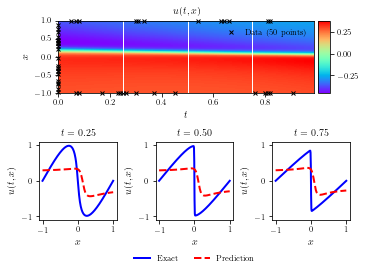

In [24]:
plot_inf_cont_results(X_star, u_pred.numpy().flatten(), X_u_train, u_train,
  Exact_u, X, T, x, t, file = "plot.pdf")

In [10]:
1-3.1513e-02

0.968487

In [13]:
# Maxls pennylane try, does not work unfortunately
import pennylane as qml


n_qubits = 2
dev = qml.device("default.qubit.tf", wires=n_qubits) # "lightning.qubit" fast, C++ device

@qml.qnode(dev)
def qnode(inputs, weights):
    qml.templates.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.templates.StronglyEntanglingLayers(weights, wires=range(n_qubits))
    return qml.expval(qml.PauliZ(0)), qml.expval(qml.PauliZ(1))

weight_shapes = {"weights": (3, n_qubits, 3)}

qlayer = qml.qnn.KerasLayer(qnode, weight_shapes, output_dim=2)

### Quantum layer

In [46]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

# TFQ / Cirq code for quantum layer: 1 node, input-vector-length = 4 (TODO: make 16)
import tensorflow_quantum as tfq
import cirq
from cirq import H, X, cphase, CNOT, Z, T
from cirq.circuits import InsertStrategy
import sympy
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit

# adapted from https://github.com/ghellstern/QuantumNN/blob/master/Multi-QBit-Classifier%20TF%20NN-Encoding_Github.ipynb
class SplitBackpropQ(tf.keras.layers.Layer):

    def __init__(self, upstream_symbols, managed_symbols, managed_init_vals,
                 operators):
        """Create a layer that splits backprop between several variables.


        Args:
            upstream_symbols: Python iterable of symbols to bakcprop
                through this layer.
            managed_symbols: Python iterable of symbols to backprop
                into variables managed by this layer.
            managed_init_vals: Python iterable of initial values
                for managed_symbols.
            operators: Python iterable of operators to use for expectation.

        """
        super().__init__(SplitBackpropQ)
        self.all_symbols = upstream_symbols + managed_symbols
        self.upstream_symbols = upstream_symbols
        self.managed_symbols = managed_symbols
        self.managed_init = managed_init_vals
        self.ops = operators

    def build(self, input_shape):
        self.managed_weights = self.add_weight(
            shape=(1, len(self.managed_symbols)),
            initializer=tf.constant_initializer(self.managed_init))

    def call(self, inputs):
        # inputs are: circuit tensor, upstream values
        upstream_shape = tf.gather(tf.shape(inputs[0]), 0)
        tiled_up_weights = tf.tile(self.managed_weights, [upstream_shape, 1])
        joined_params = tf.concat([inputs[1], tiled_up_weights], 1)
        return tfq.layers.Expectation()(inputs[0],
                                        operators=measurement,
                                        symbol_names=self.all_symbols,
                                        symbol_values=joined_params)


# TODO: Normalize weights and inputs to be between [0, pi / 2]
# TODO: replace CPhase-Gate with Multi-controlled Phase gate and use 4 qubits, Input-Size 16 instead
# 2 regular qubits, 1 ancilla
number_qubits = 3
number_regular_qubits = number_qubits - 1

# specify parameters to set later with NN inputs and weights using Keras + TFQ
regular_qubits = [cirq.GridQubit(i, 0) for i in range(number_regular_qubits)]
ancilla = cirq.GridQubit(number_regular_qubits, 0)
control_params = sympy.symbols('i0, i1, i2, i3')
control_params1 = sympy.symbols('w0, w1, w2, w3')

# specify cirq circuit
qc = cirq.Circuit()
size = len(regular_qubits) ** 2
# subtract first input from other inputs to save gates
#inputs = []
#for i in range(1, size):
    #inputs.append(control_params[i] - control_params[0])
# do the same for weights
#weights = []
#for i in range(1, size):
    #weights.append(control_params1[i] - control_params1[0])
# apply Hadamard gate to all regular qubits to create a superposition
qc.append(H.on_each(*regular_qubits))
# loop over all inputs in inputvector to encode them to the right base states using phase-shifts
for index in range(size):
    insert_list = []
    # index as binary number
    binary = '{0:02b}'.format(index)
    # get qubit at digit in binary state (positions of qubits : q0, q1, q2, q3) (figuratively, not actually, we are in superposition after all)
    for j in range(len(binary)):
        if binary[j] == '0':
            insert_list.append(X(regular_qubits[j]))
    # this_phase_gate = MCPhaseGate(value, 3, label="this_phase_gate")
    # qc.this_phase_gate(0, 1, 2, 3)
    # perform controlled phase shift (for more qubits probably possible using ControlledGate() and MatrixGate()
    insert_list.append(cphase(control_params[index])(*regular_qubits))
    # "undo" the NOT-gates to get back to previous states = apply another not
    for j in range(len(binary)):
        if binary[j] == '0':
            insert_list.append(X(regular_qubits[j]))
    qc.append(insert_list, strategy=InsertStrategy.NEW_THEN_INLINE)
# loop over weights
for w in range(size):
    insert_list = []
    # index as binary number
    binary = '{0:02b}'.format(w)
    # get qubit at digit in binary state (positions of qubits : q0, q1, q2, q3) (figuratively, not actually, we are in superposition after all)
    for j in range(len(binary)):
        if binary[j] == '0':
            insert_list.append(X(regular_qubits[j]))
    # this_phase_gate = MCPhaseGate(value, 3, label="this_phase_gate")
    # qc.this_phase_gate(0, 1, 2, 3)
    # perform conjugate transpose controlled phase shift
    insert_list.append(cphase((-1) * control_params1[w])(*regular_qubits))
    # "undo" the NOT-gates to get back to previous states = apply another not
    for j in range(len(binary)):
        if binary[j] == '0':
            insert_list.append(X(regular_qubits[j]))
    qc.append(insert_list, strategy=InsertStrategy.NEW_THEN_INLINE)
# apply Hadamard gate to all regular qubits
qc.append(H.on_each(*regular_qubits), strategy=InsertStrategy.NEW_THEN_INLINE)
# apply X gate to all regular qubits
qc.append(X.on_each(*regular_qubits), strategy=InsertStrategy.NEW_THEN_INLINE)
# collect combined state from all regular qubits with ancilla qubit using Toffoli-Gate
# Toffoli-Gate does not work in TFQ -> implement decomposition (compare https://en.wikipedia.org/wiki/Toffoli_gate#/media/File:Qcircuit_ToffolifromCNOT.svg)
qc.append([H(ancilla), CNOT(regular_qubits[1], ancilla), cirq.inverse(T(ancilla)), CNOT(regular_qubits[0], ancilla), T(ancilla), CNOT(regular_qubits[1], ancilla), cirq.inverse(T(ancilla)), CNOT(regular_qubits[0], ancilla), T(ancilla), T(regular_qubits[1]), H(ancilla), CNOT(regular_qubits[0], regular_qubits[1]), cirq.inverse(T(regular_qubits[1])), T(regular_qubits[0]), CNOT(regular_qubits[0], regular_qubits[1])], strategy=InsertStrategy.NEW_THEN_INLINE)
# draw circuit
SVGCircuit(qc)
# end circuit

# values to initialize the weights (?)
np.random.seed(seed=69)
int_values = np.random.rand((len(control_params1)))*np.pi

measurement = [Z(ancilla)]

## Quantum PINN

In [62]:
# define QPINN class
class QPhysicsInformedNN(object):
  def __init__(self, layers, optimizer, logger, X_f, ub, lb, nu, control_params, control_params1, int_values, measurement):
    # Keras model
    """self.u_model = tf.keras.Sequential()
    self.u_model.add(tf.keras.layers.InputLayer(input_shape=(layers[0],)))
    self.u_model.add(tf.keras.layers.Lambda(
      lambda X: 2.0*(X - lb)/(ub - lb) - 1.0))"""
    # one additional input layer (unused) is needed for the quantum circuit as input for the quantum layer
    self.unused = tf.keras.Input(shape=(), dtype=tf.dtypes.string, name="unused")
    self.inputs = tf.keras.layers.Input(shape=(layers[0],))
    
    # define custom layer for lambda layer
    def custom_layer(X):
        return 2.0*(X - lb)/(ub - lb) - 1.0
    self.outputs = tf.keras.layers.Lambda(custom_layer, name="lambda_layer")(self.inputs)
    
    #self.outputs = tf.keras.layers.Lambda(lambda X: 2.0*(X - lb)/(ub - lb) - 1.0)(self.inputs)
    for width in layers[1:]:
        self.outputs = tf.keras.layers.Dense(width, activation=tf.nn.tanh,
              kernel_initializer='glorot_normal')(self.outputs)
    #quantum layer
    self.outputs = SplitBackpropQ(control_params, control_params1, int_values, measurement)([self.unused, self.outputs])
    #generate model
    self.u_model = tf.keras.Model(inputs=[self.unused, self.inputs], outputs=self.outputs)
    
    #inputs = tf.keras.Input(shape=(3,))
    #x = tf.keras.layers.Dense(4, activation=tf.nn.relu)(inputs)
    #outputs = tf.keras.layers.Dense(5, activation=tf.nn.softmax)(x)
    #model = tf.keras.Model(inputs=inputs, outputs=outputs)
    """
    unused = tf.keras.Input(shape=(), dtype=tf.dtypes.string)
    inputlayer = keras.Input(shape=(32,), name="inputlayer")
    x = layers.Dense(32, activation="relu")(inputlayer)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(4, activation="relu")(x)
    x = layers.Dropout(0.5)(x)
    expectation = SplitBackpropQ(control_params, control_params1, int_values, measurement)([unused, x])
    #expectation = layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(inputs=[unused, inputlayer], outputs=expectation)"""
    
    """for width in layers[1:]:
        if width == 3:
            self.u_model.add(qlayer)
        else:
            self.u_model.add(tf.keras.layers.Dense(
              width, activation=tf.nn.tanh,
              kernel_initializer='glorot_normal'))"""

    # Computing the sizes of weights/biases for future decomposition
    self.sizes_w = []
    self.sizes_b = []
    for i, width in enumerate(layers):
      if i != 1:
        self.sizes_w.append(int(width * layers[1]))
        self.sizes_b.append(int(width if i != 0 else layers[1]))

    self.nu = nu
    self.optimizer = optimizer
    self.logger = logger

    self.dtype = tf.float32

    # Separating the collocation coordinates
    self.x_f = tf.convert_to_tensor(X_f[:, 0:1], dtype=self.dtype)
    self.t_f = tf.convert_to_tensor(X_f[:, 1:2], dtype=self.dtype)
    
  # Defining custom loss
  def __loss(self, u, u_pred):
    f_pred = self.f_model()
    return tf.reduce_mean(tf.square(u - u_pred)) + \
      tf.reduce_mean(tf.square(f_pred))

  def __grad(self, X, u):
    with tf.GradientTape() as tape:
      loss_value = self.__loss(u, self.u_model(X))
    return loss_value, tape.gradient(loss_value, self.__wrap_training_variables())

  def __wrap_training_variables(self):
    var = self.u_model.trainable_variables
    return var

  # The actual PINN
  def f_model(self):
    # Using the new GradientTape paradigm of TF2.0,
    # which keeps track of operations to get the gradient at runtime
    with tf.GradientTape(persistent=True) as tape:
      # Watching the two inputs we’ll need later, x and t
      tape.watch(self.x_f)
      tape.watch(self.t_f)
      # Packing together the inputs
      X_f = tf.stack([self.x_f[:,0], self.t_f[:,0]], axis=1)

      # Getting the prediction
      u = self.u_model(X_f)
      # Deriving INSIDE the tape (since we’ll need the x derivative of this later, u_xx)
      u_x = tape.gradient(u, self.x_f)
    
    # Getting the other derivatives
    u_xx = tape.gradient(u_x, self.x_f)
    u_t = tape.gradient(u, self.t_f)

    # Letting the tape go
    del tape

    nu = self.get_params(numpy=True)

    # Buidling the PINNs
    return u_t + u*u_x - nu*u_xx

  def get_params(self, numpy=False):
    return self.nu

  def get_weights(self):
    w = []
    for layer in self.u_model.layers[1:]:
      weights_biases = layer.get_weights()
      weights = weights_biases[0].flatten()
      biases = weights_biases[1]
      w.extend(weights)
      w.extend(biases)
    return tf.convert_to_tensor(w, dtype=self.dtype)

  def set_weights(self, w):
    for i, layer in enumerate(self.u_model.layers[1:]):
      start_weights = sum(self.sizes_w[:i]) + sum(self.sizes_b[:i])
      end_weights = sum(self.sizes_w[:i+1]) + sum(self.sizes_b[:i])
      weights = w[start_weights:end_weights]
      w_div = int(self.sizes_w[i] / self.sizes_b[i])
      weights = tf.reshape(weights, [w_div, self.sizes_b[i]])
      biases = w[end_weights:end_weights + self.sizes_b[i]]
      weights_biases = [weights, biases]
      layer.set_weights(weights_biases)

  def summary(self):
    return self.u_model.summary()

  # The training function
  def fit(self, X_u, u, tf_epochs=5000, nt_config=Struct()):
    self.logger.log_train_start(self)

    # Creating the tensors
    X_u = tf.convert_to_tensor(X_u, dtype=self.dtype)
    u = tf.convert_to_tensor(u, dtype=self.dtype)

    self.logger.log_train_opt("Adam")
    for epoch in range(tf_epochs):
      # Optimization step
      loss_value, grads = self.__grad(X_u, u)
      self.optimizer.apply_gradients(zip(grads, self.__wrap_training_variables()))
      self.logger.log_train_epoch(epoch, loss_value)
    
    self.logger.log_train_opt("LBFGS")
    def loss_and_flat_grad(w):
      with tf.GradientTape() as tape:
        self.set_weights(w)
        loss_value = self.__loss(u, self.u_model(X_u))
      grad = tape.gradient(loss_value, self.u_model.trainable_variables)
      grad_flat = []
      for g in grad:
        grad_flat.append(tf.reshape(g, [-1]))
      grad_flat =  tf.concat(grad_flat, 0)
      return loss_value, grad_flat
    # tfp.optimizer.lbfgs_minimize(
    #   loss_and_flat_grad,
    #   initial_position=self.get_weights(),
    #   num_correction_pairs=nt_config.nCorrection,
    #   max_iterations=nt_config.maxIter,
    #   f_relative_tolerance=nt_config.tolFun,
    #   tolerance=nt_config.tolFun,
    #   parallel_iterations=6)
    """lbfgs(loss_and_flat_grad,
      self.get_weights(),
      nt_config, Struct(), True,
      lambda epoch, loss, is_iter:
        self.logger.log_train_epoch(epoch, loss, "", is_iter))"""

    self.logger.log_train_end(tf_epochs + nt_config.maxIter)

  def predict(self, X_star):
    u_star = self.u_model(X_star)
    f_star = self.f_model()
    return u_star, f_star

### Hyperparameters quantum PINN

In [63]:
# Data size on the solution u
N_u = 50
# Collocation points size, where we’ll check for f = 0
N_f = 10000
# DeepNN topology (2-sized input [x t], 8 hidden layer of 20-width, 1-sized output [u]

layers = [2, 20, 20, 20, 20, 20, 20, 20, 20, 1]

# Setting up the TF SGD-based optimizer (set tf_epochs=0 to cancel it)
tf_epochs = 1000
tf_optimizer = tf.keras.optimizers.Adam(
  learning_rate=0.3,
  beta_1=0.99,
  epsilon=1e-1)
# Setting up the quasi-newton LBGFS optimizer (set nt_epochs=0 to cancel it)
nt_epochs = 500 # 2000
nt_config = Struct()
nt_config.learningRate = 0.8
nt_config.maxIter = nt_epochs
nt_config.nCorrection = 50
nt_config.tolFun = 1.0 * np.finfo(float).eps

### Train model

In [64]:
# Getting the data
path = os.path.join(appDataPath, "burgers_shock.mat")
x, t, X, T, Exact_u, X_star, u_star, \
  X_u_train, u_train, X_f, ub, lb = prep_data(path, N_u, N_f, noise=0.0)

# Creating the model and training
logger = Logger(frequency=10)
nu=0.01/np.pi
qpinn = QPhysicsInformedNN(layers, tf_optimizer, logger, X_f, ub, lb, nu, control_params, control_params1, int_values, measurement)
def error():
  u_pred, _ = qpinn.predict(X_star)
  return np.linalg.norm(u_star - u_pred, 2) / np.linalg.norm(u_star, 2)
logger.set_error_fn(error)
qpinn.fit(X_u_train, u_train, tf_epochs, nt_config)

# Getting the model predictions, from the same (x,t) that the predictions were previously gotten from
u_pred, f_pred = qpinn.predict(X_star)

TensorFlow version: 2.3.1
Eager execution: True
GPU-accerelated: False

Training started
Model: "functional_21"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_18 (InputLayer)           [(None, 2)]          0                                            
__________________________________________________________________________________________________
lambda_layer (Lambda)           (None, 2)            0           input_18[0][0]                   
__________________________________________________________________________________________________
dense_122 (Dense)               (None, 20)           60          lambda_layer[0][0]               
__________________________________________________________________________________________________
dense_123 (Dense)               (None, 20)           420         dense_122[0][0]                

UnimplementedError: Cast float to string is not supported [Op:Cast]

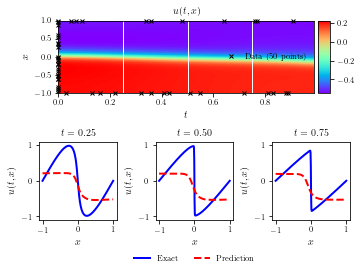

In [65]:
plot_inf_cont_results(X_star, u_pred.numpy().flatten(), X_u_train, u_train,
  Exact_u, X, T, x, t, file = "qplot.pdf")